In [6]:
import pandas as pd
import numpy as np

experiments = dict(
    p10='p = 1',
    p8='p = 0.8',
    p6='p = 0.6',
    p4='p = 0.4',
    p2='p = 0.2',
    p0='p = 0',
)
seeds = [f's{i}' for i in range(1, 11)]
specialists = {}
stats = []

base_dir = '../../datalake/wcci'

for experiment, proportion in experiments.items():
    experiment_dir = f'{base_dir}/{experiment}/data/xdpole'
    specialist_data = f'{experiment_dir}/main_manager/main_stats'
    stats_data = f'{experiment_dir}/runstats'
    specialist_mean = []
    specialist_score = []
    for seed in seeds:
        seed_stats = pd.read_csv(f'{stats_data}/{seed}_run.csv')
        seed_test = pd.read_csv(f'{stats_data}/{seed}_test.csv')
        seed_specialist = pd.read_csv(f'{specialist_data}/{seed}_run.csv')
        specialist_score.append(
            list(seed_specialist.specialist_score)
        )
        cg = seed_specialist.query('specialist_score >= 0.8').specialist_score.count()
        g = seed_stats.gen.max() - 1000
        stats.append(dict(
            seed=seed,
            experiment=experiment,
            bestgfit=seed_stats.bestgfit.max(),
            generations=g,
            start=seed_stats[seed_stats.gen == 1000].msteps.item(),
            curriculum_proportion=proportion,
            curriculum_usage=cg/g,
            curriculum_generations=cg,
            score=seed_test.score[0]
        ))
        
    specialists[experiment] = specialist_score

df = pd.DataFrame(stats)

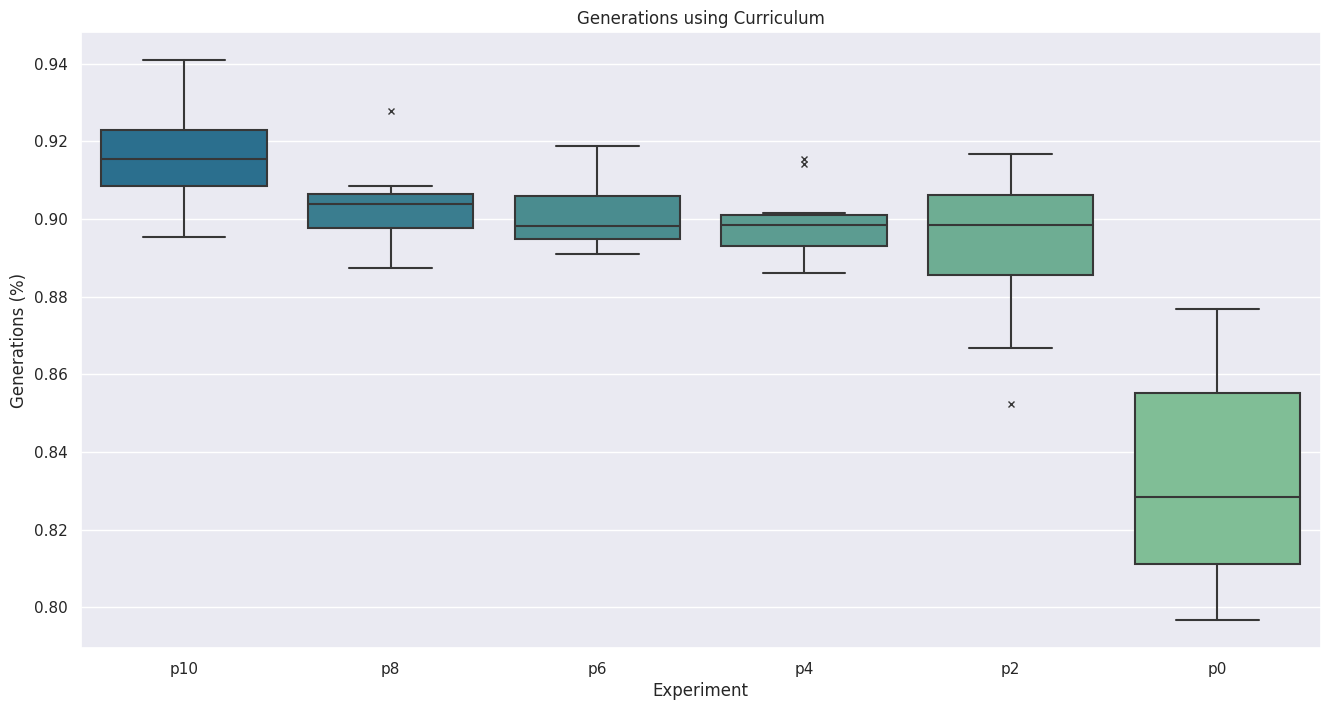

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set(rc={'figure.figsize':(16,8)})

palette = 'blend:#1a759f,#76c893'
sns.boxplot(data=df, x='experiment', y='curriculum_usage', flierprops={"marker": "x"}, palette=palette)
plt.title("Generations using Curriculum")
plt.ylabel("Generations (%)")
plt.xlabel("Experiment")
plt.show()

<Axes: xlabel='score', ylabel='Count'>

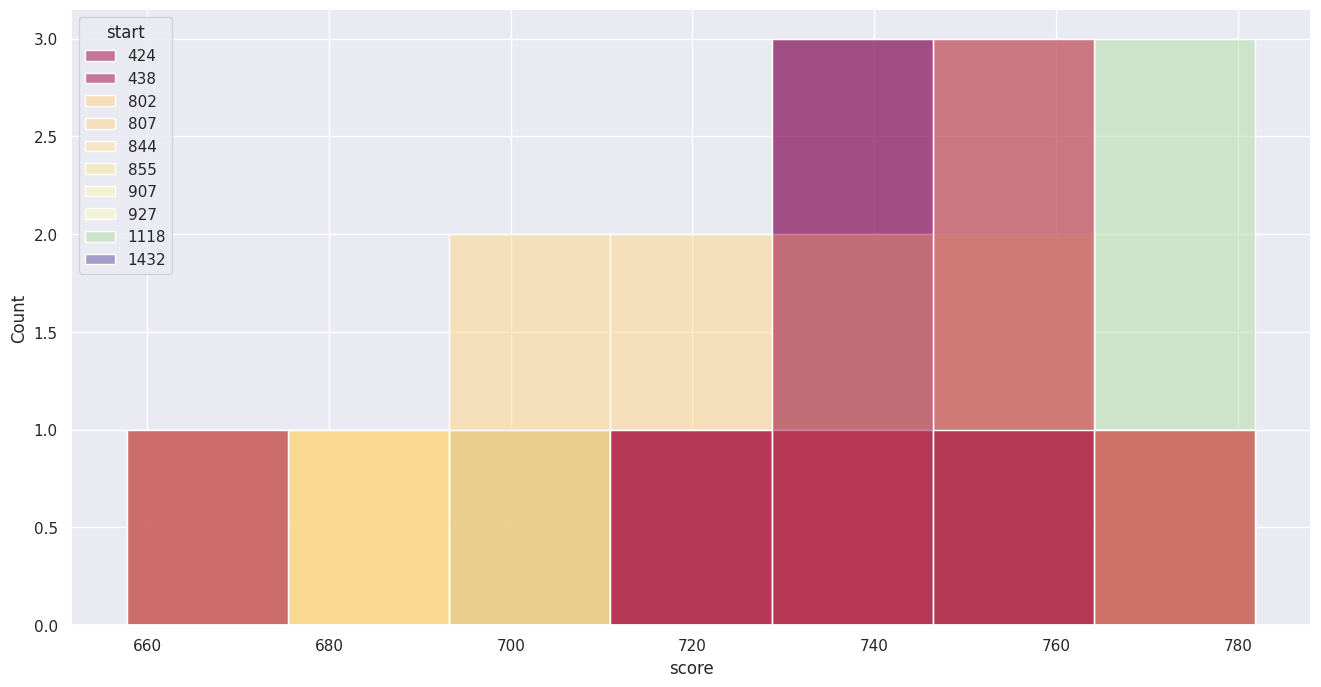

In [8]:
df = pd.DataFrame(stats)

sns.histplot(data=df, x='score', hue='start', palette='Spectral')

<Axes: xlabel='seed', ylabel='score'>

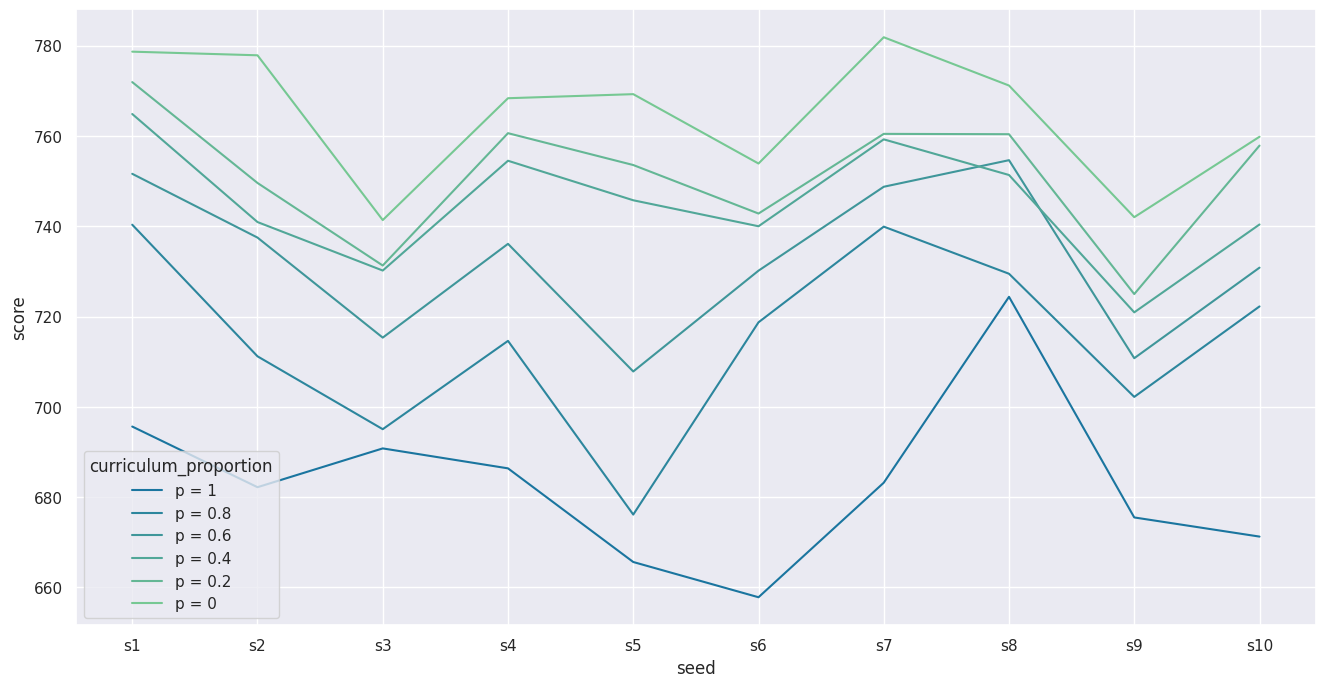

In [9]:
df = pd.DataFrame(stats)

palette = 'blend:#1a759f,#76c893'
sns.lineplot(data=df, x='seed', y='score', hue='curriculum_proportion', palette=palette)

<Axes: xlabel='curriculum_proportion', ylabel='generations'>

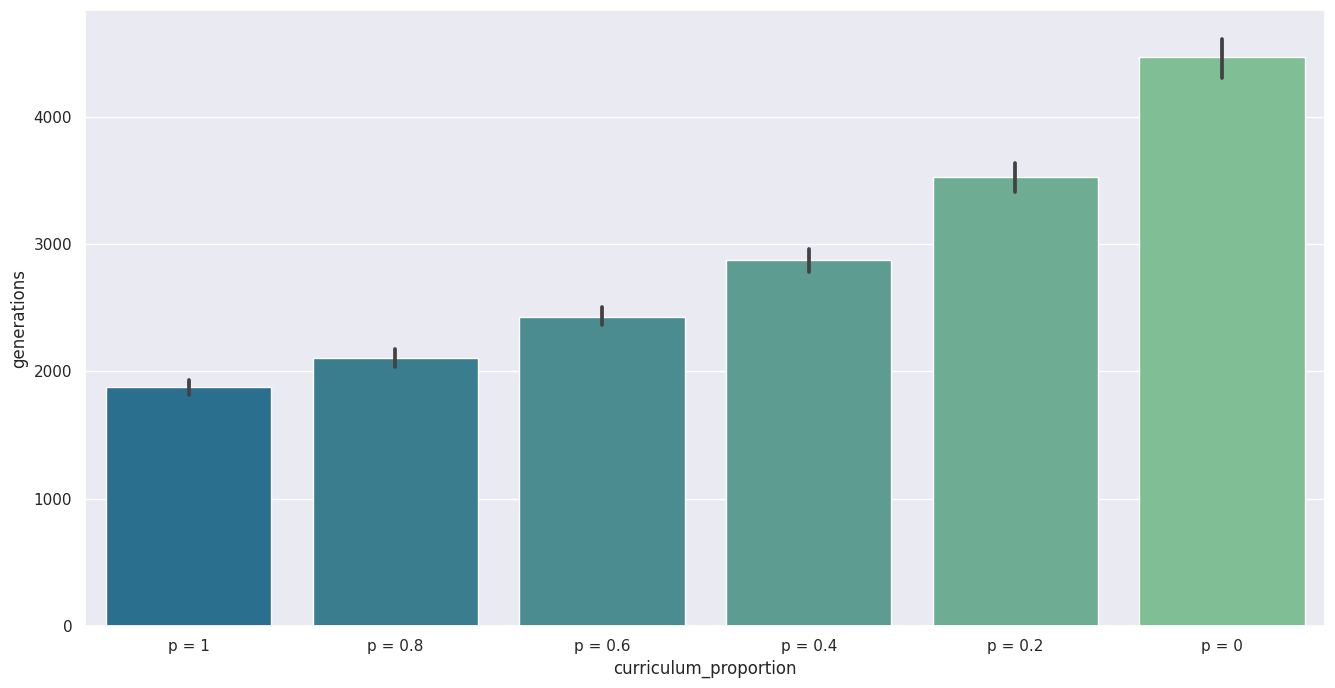

In [10]:
df = pd.DataFrame(stats)

palette = 'blend:#1a759f,#76c893'
sns.barplot(data=df, y='generations', x='curriculum_proportion', palette=palette)